Notebook based based on Kaggle official notebook for the competition: https://github.com/planetlabs/planet-amazon-deforestation/blob/master/planet_chip_examples.ipynb
Planet: Understanding the Amazon from Space challenge

This notebook show some exploration of the images and label files.

In [3]:
import sys
import os
import subprocess

from six import string_types

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

Number of training images.

In [5]:
!ls -lha /Users/jcq/Code/Kaggle/Amazon_from_space/data/train-tif-v2 | wc -l

   40482


## Setup
Set PLANET_KAGGLE_ROOT to the proper directory where we've got the TIFF and JPEG zip files, and accompanying CSVs.

In [14]:
PLANET_KAGGLE_ROOT = os.path.abspath("/Users/jcq/Code/Kaggle/Amazon_from_space/data")
PLANET_KAGGLE_TIF_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-tif-v2')
PLANET_KAGGLE_TIF_DIR_RED = os.path.join(PLANET_KAGGLE_ROOT, 'train-tif')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_TIF_DIR)
assert os.path.exists(PLANET_KAGGLE_TIF_DIR_RED)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

## Inspect image labels
The labels are in a CSV entitled train.csv. Note that each image can be tagged with multiple tags. We'll convert them to a "one hot" style representation where each label is a column:

In [15]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [16]:
# Build list with all the unique labels
label_list = []
# Loop over all the tags
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    # Loop over all the words in a tag
    for label in labels:
        if label not in label_list:
            label_list.append(label)

# Create a column and Add onehot features for every label to the label dataframe
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


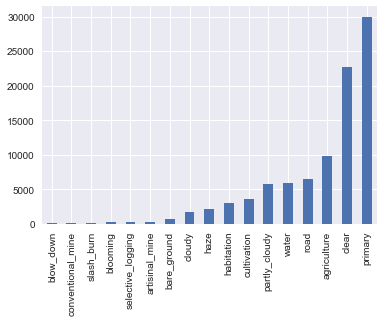

In [18]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2171,2148,550,0,499,110,326,158,2,0,0,2,30,5,2,5,0
primary,2148,29979,9560,22135,5630,2799,6206,3547,162,0,5696,80,531,257,266,268,78
agriculture,550,9560,9829,7311,2196,2193,4842,2684,93,0,1968,19,169,31,22,49,17
clear,0,22135,7311,22748,4435,2499,5059,2808,134,0,0,60,583,243,248,240,67
water,499,5630,2196,4435,5971,743,1717,697,19,0,1036,20,163,240,12,39,3
habitation,110,2799,2193,2499,743,2947,2249,721,30,0,338,31,125,21,3,10,2
road,326,6206,4842,5059,1717,2249,6476,1031,30,0,1091,47,247,88,8,117,0
cultivation,158,3547,2684,2808,697,721,1031,3563,93,0,597,4,62,15,26,47,8
slash_burn,2,162,93,134,19,30,30,93,162,0,26,0,9,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,1700,0,0,0,0,0,0,0


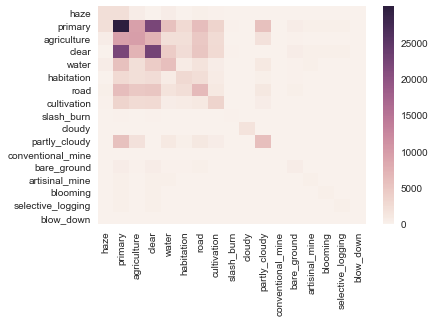

In [19]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

,clear,partly_cloudy,haze,cloudy
clear,22748,0,0,0
partly_cloudy,0,5764,0,0
haze,0,0,2171,0
cloudy,0,0,0,1700


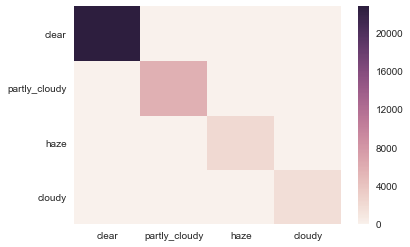

In [20]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

,primary,agriculture,water,cultivation,habitation
primary,29979,9560,5630,3547,2799
agriculture,9560,9829,2196,2684,2193
water,5630,2196,5971,697,743
cultivation,3547,2684,697,3563,721
habitation,2799,2193,743,721,2947


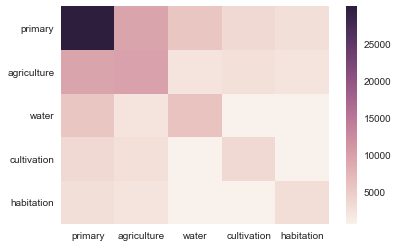

In [21]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

,slash_burn,cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,162,0,0,9,0,2,2,2
cloudy,0,1700,0,0,0,0,0,0
conventional_mine,0,0,83,10,3,0,0,0
bare_ground,9,0,10,666,28,3,9,2
artisinal_mine,0,0,3,28,270,0,4,0
blooming,2,0,0,3,0,266,4,1
selective_logging,2,0,0,9,4,4,268,1
blow_down,2,0,0,2,0,1,1,78


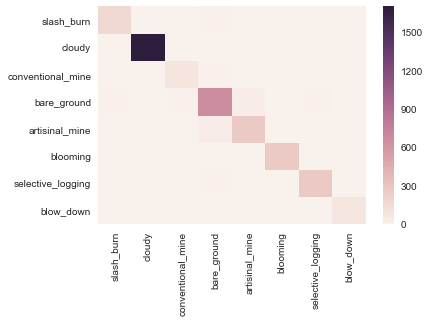

In [22]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)

## Inspect images
Display images and their corresponding labels.

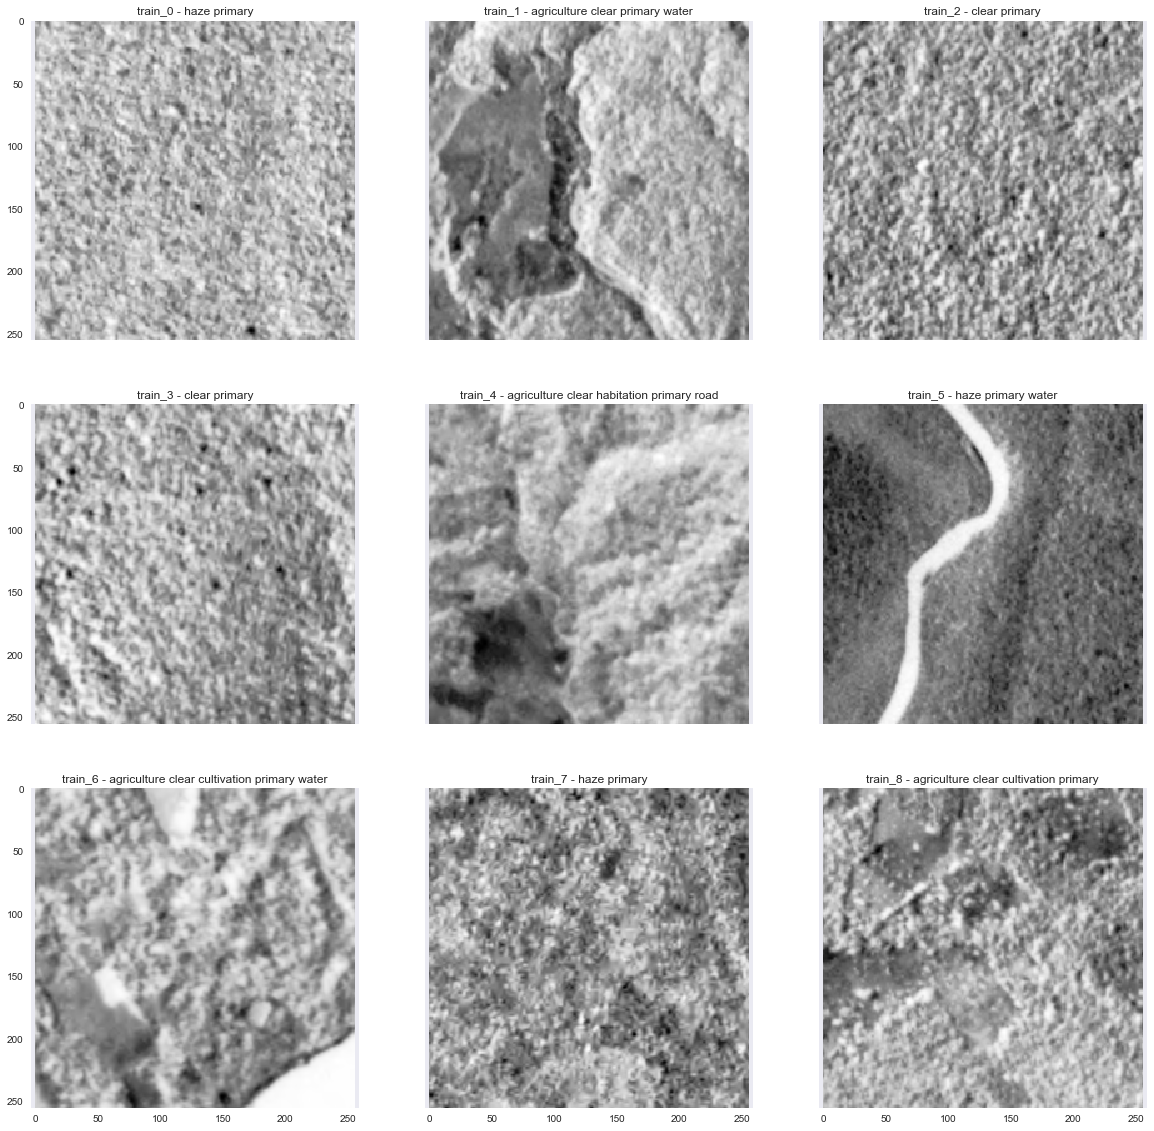

In [34]:
import cv2

df_train = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:9].values:
    img = cv2.imread('data/train-tif-v2/{}.tif'.format(f), -1)
    img = img[:,:,3]
    #ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].imshow(img)
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()